In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk
from datetime import date




url="https://uzmanpara.milliyet.com.tr/canli-borsa/bist-TUM-hisseleri/"
r=requests.get(url)
soup=BeautifulSoup(r.content,"html.parser")

bs=BeautifulSoup(r.content, "lxml")
data=soup.find("div",{"class":"box box10 last"})



In [8]:
data=soup.find("tr",{"id":"h_tr_id_KCHOL"})


In [9]:
data=soup.find("td",{"id":"h_td_fiyat_id_KCHOL"})
text=data.text

In [10]:
text=text.replace(',', '.')
text=float(text)
text

99.4

In [3]:
kchol=pd.read_csv("/Users/Bora/Documents/GitHub/Borsa-Hisse-Analizi/kchol.csv")
kchol.index=pd.to_datetime(kchol["Date"])


In [4]:
del kchol["Date"]

In [5]:
kchol=pd.DataFrame(kchol)

In [6]:
kchol

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-01-04,20.08,20.00,20.36,19.93,10.53M,0.40%
2021-01-05,20.02,19.89,20.46,19.76,15.65M,-0.30%
2021-01-06,20.02,20.12,20.21,19.76,12.23M,0.00%
2021-01-07,19.98,20.08,20.14,19.78,7.91M,-0.20%
2021-01-08,20.38,20.10,20.38,20.00,10.36M,2.00%
...,...,...,...,...,...,...
2023-06-12,101.00,104.60,105.50,101.00,22.71M,-2.51%
2023-06-13,99.60,100.60,102.50,97.70,30.46M,-1.39%
2023-06-14,99.30,99.95,103.60,98.30,32.30M,-0.30%


In [7]:
close=pd.DataFrame(kchol["Price"])

close


,Price
Date,
2021-01-04,20.08
2021-01-05,20.02
2021-01-06,20.02
2021-01-07,19.98
2021-01-08,20.38
...,...
2023-06-12,101.00
2023-06-13,99.60
2023-06-14,99.30


In [12]:
dict={'Date':date.today(),'Price':text}
df=pd.DataFrame.from_dict(dict,orient="index")
df=df.T
df.reset_index()
df

,Date,Price
0,2023-06-18,99.4


In [13]:
df.set_index=df["Date"]
df

,Date,Price
0,2023-06-18,99.4


In [14]:
df.index=df["Date"]

In [15]:
del df["Date"]

In [16]:
df.index=pd.to_datetime(df.index)
df

,Price
Date,
2023-06-18,99.4


In [15]:
close=pd.concat([close,df])
close

,Price
Date,
2021-01-04,20.08
2021-01-05,20.02
2021-01-06,20.02
2021-01-07,19.98
2021-01-08,20.38
...,...
2023-06-13,99.6
2023-06-14,99.3
2023-06-15,101.0


In [8]:
rolling_app5=close.rolling(window=5).mean()
rolling_app14=close.rolling(window=13).mean()
rolling_app21=close.rolling(window=21).mean()



In [9]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [10]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2021-02-01,19.36,19.552,20.370769,20.372381
2021-02-02,19.51,19.386,20.260000,20.345238
2021-02-03,20.31,19.580,20.261538,20.359048
2021-02-04,20.42,19.746,20.213846,20.378095
2021-02-05,20.14,19.948,20.138462,20.385714
...,...,...,...,...
2023-06-12,101.00,99.740,87.884615,85.169048
2023-06-13,99.60,100.880,89.926923,85.300000
2023-06-14,99.30,100.740,91.796154,85.876190


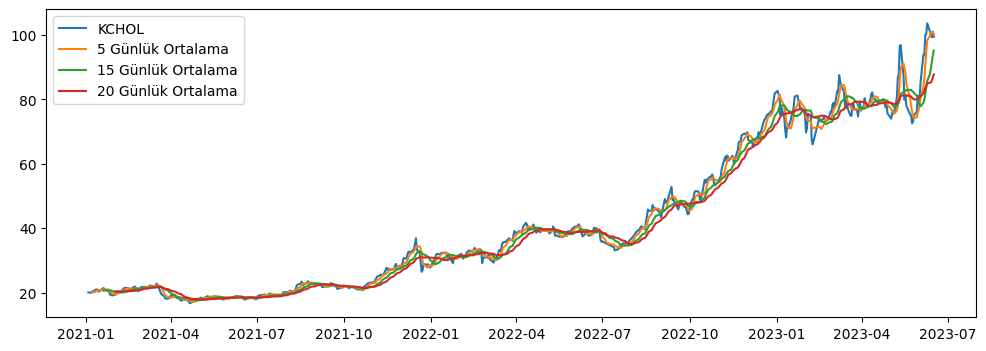

In [11]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='KCHOL')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='15 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='20 Günlük Ortalama')
ax.legend(loc='upper left')


In [40]:
def buy_sell(data,perc=50):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    sm=np.abs(np.percentile(np.array(data["short"]-data["mid"]),perc))
    sl=np.abs(np.percentile(np.array(data["short"]-data["long"]),perc))

    for i in range(0,len(data)):
        if (data["short"][i]>data["mid"][i]+sm) & (data["short"][i]>data["long"][i]+sl):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
        elif (data["short"][i]<data["mid"][i]-sm)&(data["short"][i]<data["long"][i]-sl):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    operations=operations[neg:-pos]
    PL=np.sum(operations)

    return (buy_signal,sell_signal,PL)


In [41]:
m=buy_sell(MAs)
MAs["Al"]=m[0]
MAs["Sat"]=m[1]

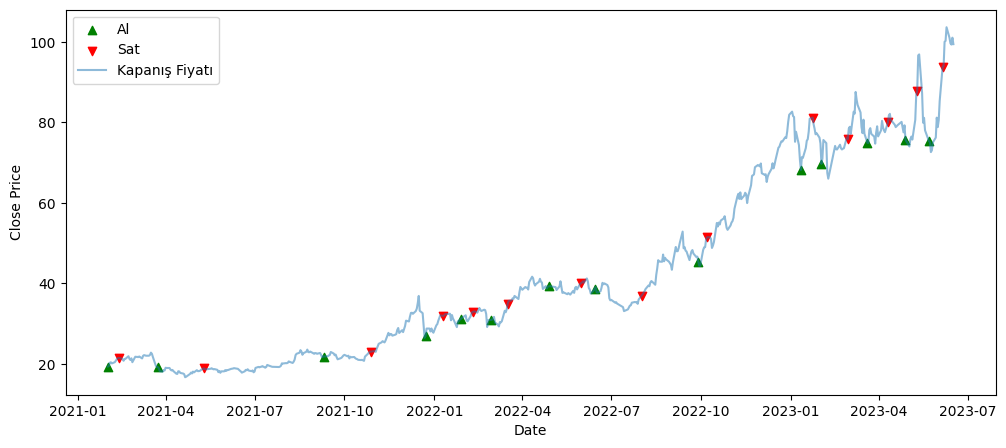

In [42]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Al"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sat"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [55]:
al=MAs["Al"]
al=al.dropna(axis=0)
al

Date
2021-02-01    19.36
2021-03-24    19.25
2021-09-10    21.85
2021-12-23    26.93
2022-01-28    31.20
2022-02-28    30.94
2022-04-28    39.26
2022-06-14    38.67
2022-09-28    45.40
2023-01-11    68.17
2023-02-01    69.68
2023-03-20    74.92
2023-04-28    75.65
2023-05-22    75.30
Name: Al, dtype: float64

In [56]:
sat=MAs["Sat"]
sat=sat.dropna(axis=0)
sat


Date
2021-02-12    21.50
2021-05-10    18.92
2021-10-28    23.06
2022-01-10    31.92
2022-02-10    32.98
2022-03-17    34.99
2022-05-31    40.08
2022-08-01    36.93
2022-10-07    51.49
2023-01-23    81.18
2023-02-28    75.85
2023-04-10    80.00
2023-05-10    87.85
2023-06-05    93.80
Name: Sat, dtype: float64

In [82]:
del sat["2021-03-05"]

In [57]:
sat_val=sat.values
al_val=al.values


In [58]:
sat_val1=sat_val

In [59]:
sat_val1

array([21.5 , 18.92, 23.06, 31.92, 32.98, 34.99, 40.08, 36.93, 51.49,
       81.18, 75.85, 80.  , 87.85, 93.8 ])

In [60]:
al_val1=al_val
al_val1

array([19.36, 19.25, 21.85, 26.93, 31.2 , 30.94, 39.26, 38.67, 45.4 ,
       68.17, 69.68, 74.92, 75.65, 75.3 ])

In [61]:
res=[]

for i in range(len(al_val1)):
    res.append((sat_val1[i]/al_val1[i]))

In [62]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,1.110537
1,0.982857
2,1.055378
3,1.185295
4,1.057051
5,1.130899
6,1.020886
7,0.955004
8,1.134141
9,1.190846


In [63]:
res0=[100]
for i in range(14):
    res0.append(res0[i]*df["Kar"].loc[i])


In [64]:
df["Eldeki Para"]=res0[1:]
df

,Kar,Eldeki Para
0,1.110537,111.053719
1,0.982857,109.149941
2,1.055378,115.194400
3,1.185295,136.539370
4,1.057051,144.329117
5,1.130899,163.221583
6,1.020886,166.630694
7,0.955004,159.132959
8,1.134141,180.479209
9,1.190846,214.923019


In [65]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 261.3793136176559


## Her sat tavsiyesinde satmayıp 2.sat tavsiyesinde satarsak ne olur?(Yani 1 adet sat tavsiyesini pas geçersek)

In [66]:
sat_val2=sat_val[1:14:2]

In [67]:
sat_val2

array([18.92, 31.92, 34.99, 36.93, 81.18, 80.  , 93.8 ])

In [68]:
al_val2=al_val[0:14:2]
al_val2

array([19.36, 21.85, 31.2 , 39.26, 45.4 , 69.68, 75.65])

In [70]:
res1=[]

for i in range(7):
    res1.append((sat_val2[i]/al_val2[i]))

In [71]:
df1=pd.DataFrame()
df1["Kar"]=res1
df1

,Kar
0,0.977273
1,1.460870
2,1.121474
3,0.940652
4,1.788106
5,1.148106
6,1.239921


In [72]:
res2=[100]
for i in range(7):
    res2.append(res2[i]*df1["Kar"].loc[i])




In [73]:
df1["Eldeki Para"]=res2[1:]
df1


,Kar,Eldeki Para
0,0.977273,97.727273
1,1.460870,142.766798
2,1.121474,160.109304
3,0.940652,150.607147
4,1.788106,269.301502
5,1.148106,309.186569
6,1.239921,383.366824


In [74]:
karlilik=df1["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 283.3668235496125
